In [60]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split as split_data
from skimage.io import imread
import cv2
import os

import tensorflow as tf
from tensorflow.keras import models
from keras.models import Model, Sequential
from keras.layers import Input, Activation, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import save_img
from tensorflow.keras.utils import img_to_array
from sklearn.metrics import classification_report


In [33]:
train_dir = "splitted_dataset/train"
valid_dir = "splitted_dataset/val"

# melakukan augmentasi data
datagen = ImageDataGenerator(
    rescale = 1./255,   #normalisasi nilai citra dari range 0-255 menjadi 0-1
    rotation_range = 20, #random rotation range 20 derajat
    zoom_range = 0.2, #zoom
    shear_range = 0.2, #shear
    width_shift_range = 0,
    height_shift_range = 0,
    vertical_flip = False,
    horizontal_flip= True, #flip kiri kanan, jika kamera dalam mirror mode seperti kamera depan hp
    fill_mode = 'nearest'
                    )

In [34]:
# generate dataset, dengan batc size 32, ukuran batch mempengaruhi jumlah step dimana jumlah step setiap epoch = jumlah total dataset/batch size
train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128), #spesifikasi ukuran data 
        batch_size=32,
        class_mode='binary', #krn hanya terdapat 2 class yakni yes (menggunakan mask) dan no (tidak mask)
        color_mode='grayscale' #fitur yang diperlukan adala dari titik titik wajah, jadi grayscale seharusnya cukup, beserta untuk memperkecil range warna, dataset menggunakan warna mask yang berbeda beda
        )

validation_generator = datagen.flow_from_directory(
        valid_dir,
        target_size=(128, 128),
        batch_size=32,
        shuffle = False,
        color_mode='grayscale',
        class_mode='binary')

Found 955 images belonging to 2 classes.
Found 119 images belonging to 2 classes.


In [35]:
train_generator.image_shape

(128, 128, 1)

In [36]:
# nantinya akan dibawa ke testing
train_generator.class_indices

{'no': 0, 'yes': 1}

In [45]:
class_map = {'no': 0, 'yes': 1}

In [37]:
model = tf.keras.models.Sequential([
    # extraction layer
    # input
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # classificaton layer
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    # output 1 krn menggunakan binary
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 64)      

In [38]:
# binary classification sangat cocok untuk menggunakan optimizer adam
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss=['binary_crossentropy'], metrics=["accuracy"], optimizer=adam)

/home/zan/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
# callback membantu proses training agar lebih efisien, mulai dari early stop, check point, sampai dengan custom callback

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

modelFolder = 'result/'

# checkpoint ini memungkinkan weight disimpan pada saat loss training mencapai titik minimum
checkpointLoss = ModelCheckpoint(f"{modelFolder}bestLoss.hdf5", 
                            monitor='loss', 
                            verbose=1,
                            save_best_only=True, 
                            mode='auto')

# checkpoint ini memungkinkan weight disimpan pada saat loss training pada tahap validation mencapai titik minimum
checkpointValLoss = ModelCheckpoint(f"{modelFolder}bestValLoss.hdf5", 
                            monitor='val_loss', 
                            verbose=1,
                            save_best_only=True, 
                            mode='auto')

# checkpoint early stop memungkinkan model untuk langsung berhenti melakukan proses training ketika
# tidak terdapat penurunan loss (semakin kecil locc semakin bagus). 
# patience = 10, menandakan model akan berhenti ketika tidak ada lagi minimum loss yang didapatkan selama 10 epochs berturut turut
earlyStopVal = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

# callback khusus yang akan langsung memberhentikan model ketika sudah mencapain akurasi dan loss yang cukup, yakni 95% akurasi dengan loss 0.001
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('loss')<0.001):
            print("\nAkurasi telah mencapai > 95%! dan loss < 0.001")
            self.model.stop_training = True

callbacks = myCallback()

In [40]:
# melakukan traning model dengan memberikan data train dan data validattion
# beserta dengan jumlah epoch maximum dan callback callback yang diperlukan
# krn jumlah dataset yang terbilang cukup, maka callback yang digunakan adalah callback yang berfokus pada peningkatan performa validation (checkpointvalloss dan earlystopval)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=60,
    callbacks=[callbacks,
               checkpointValLoss,
               earlyStopVal
               ],
)


Epoch 1/60
30/30 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5414
Epoch 00001: val_loss improved from inf to 0.68437, saving model to result/bestValLoss.hdf5
30/30 [==============================] - 18s 567ms/step - loss: 0.6893 - accuracy: 0.5414 - val_loss: 0.6844 - val_accuracy: 0.4958
Epoch 2/60
30/30 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.5927
Epoch 00002: val_loss improved from 0.68437 to 0.66842, saving model to result/bestValLoss.hdf5
30/30 [==============================] - 19s 616ms/step - loss: 0.6728 - accuracy: 0.5927 - val_loss: 0.6684 - val_accuracy: 0.5042
Epoch 3/60
30/30 [==============================] - ETA: 0s - loss: 0.6335 - accuracy: 0.6691
Epoch 00003: val_loss improved from 0.66842 to 0.60070, saving model to result/bestValLoss.hdf5
30/30 [==============================] - 17s 572ms/step - loss: 0.6335 - accuracy: 0.6691 - val_loss: 0.6007 - val_accuracy: 0.8235
Epoch 4/60
30/30 [====================

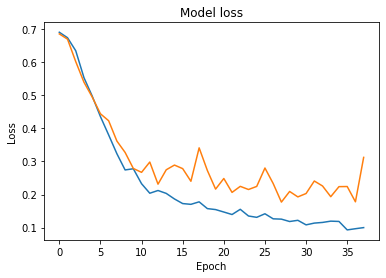

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

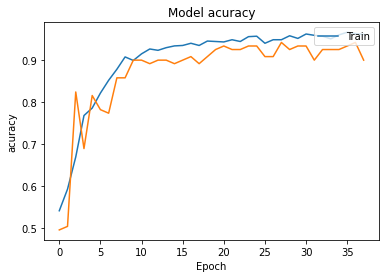

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acuracy')
plt.ylabel('acuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [ ]:
'''
performa model bisa dibilang relatif bagus krn tidak ada spike yang terlalu tinggi dan peningkatan akurasi dan loss setiap epoch bisa dibilang sangat stabil
'''

In [43]:
import pandas as pd
df = pd.DataFrame()
df["accuracy"] = history.history["accuracy"]
df["val_accuracy"] = history.history['val_accuracy']
df["loss"] = history.history['loss']
df["val_loss"] = history.history["val_loss"]
df.to_csv(f"{modelFolder}history.csv")
# menyimpan history sebagai dokumentasi

In [47]:
# testing model
loaded_model = models.load_model('result/bestValLoss.hdf5')

In [57]:
testing_data = []
labels = []
testing_path = 'splitted_dataset/test'
for label in os.listdir(testing_path):
  path = testing_path+'/'+label
  for filename in os.listdir(path):
    img_path = path+'/'+filename
    img = load_img(img_path, color_mode='grayscale')
    img = img_to_array(img).astype(np.uint8)
    testing_data.append(img)
    labels.append(class_map[label])

testing_data = np.array(testing_data)/255

In [58]:
testing_data.shape
# totl terdapat 120 datatest

(120, 128, 128, 1)

In [74]:
pred = model.predict(testing_data)
prob_pred = np.concatenate((1-pred, pred), axis=1)
prob_pred.shape
# krn merupakan classifikasi binary, jadi return nilai confidence hanya 1, jadi harus diubah menjadi 2 nilai confidence dengan cara 1-nilaiconfidence

(120, 2)

In [75]:
y_pred = [np.argmax(i) for i in prob_pred]
# melakukan mengambilan indek yang mimiliki nilai terbesar pada setiap baris

In [76]:
print(classification_report(labels, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91        60
           1       0.98      0.83      0.90        60

    accuracy                           0.91       120
   macro avg       0.92      0.91      0.91       120
weighted avg       0.92      0.91      0.91       120



In [ ]:
# klasifikasi rata rata menghasilkan akurasi 91%, nilai yang cukup bagus untuk model sekuensial, 
# yang difokuskan dalam pengembangan model ini adalah performa krn akan diimplementasikan pada cctv tempaat tempat umum